In [1]:
#importing various libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
from nltk.tokenize.toktok import ToktokTokenizer
from wordcloud import WordCloud

In [2]:
#Load dataset
df = pd.read_csv("IMDB Dataset.csv")

In [3]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [4]:
#exploring the dataset
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
df['sentiment'].value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

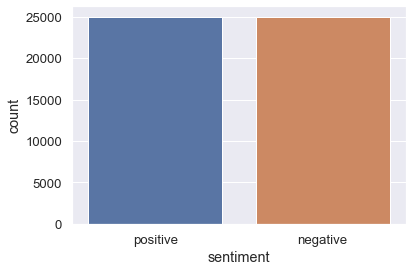

In [6]:
sns.set(style = "darkgrid" , font_scale = 1.2)
sns.countplot(df.sentiment)

So we can see there are 2 columns - review and sentiment. sentiment is the target column that we need to predict. The dataset is completely balanced and it has equal number of positive and negative sentiments

In [7]:
X=df.iloc[:,0].values
y=df.iloc[:,-1].values

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1)

In [8]:
X_train.shape

(40000,)

In [9]:
y_train.shape

(40000,)

In [10]:
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

In [11]:
#First of all we will remove HTML contents
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
df['review']=df['review'].apply(denoise_text)
df['review']=df['review'].apply(remove_between_square_brackets)

In [12]:
#Stopwords removal - since stopwords removal works on every word in your text we need to split the text
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Apply function on review column
df['review']=df['review'].apply(remove_stopwords)

In [13]:
#we will remove everything except lower/upper case letters using Regular Expressions
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
df['review']=df['review'].apply(remove_special_characters)

In [14]:
df.sentiment.replace("positive" , 1 , inplace = True)
df.sentiment.replace("negative" , 0 , inplace = True)

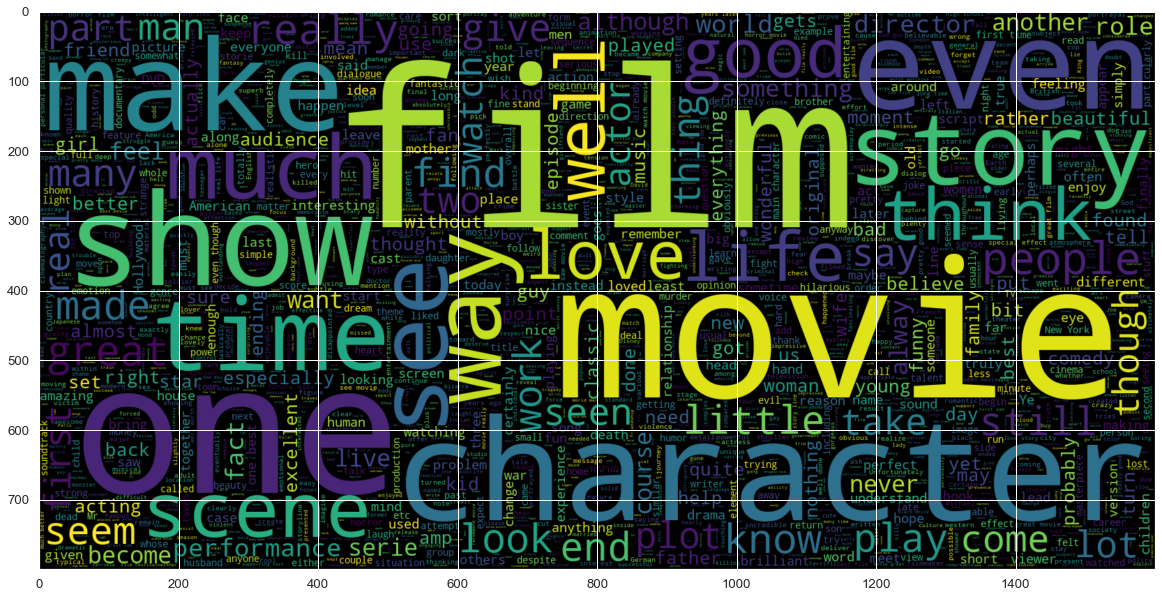

In [145]:
df.sentiment.replace("positive" , 1 , inplace = True)
df.sentiment.replace("negative" , 0 , inplace = True)
#WORDCLOUD FOR POSITIVE TEXT (LABEL - 1)
plt.figure(figsize = (20,20)) # Positive Review Text
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 1].review))
plt.imshow(wc , interpolation = 'bilinear')

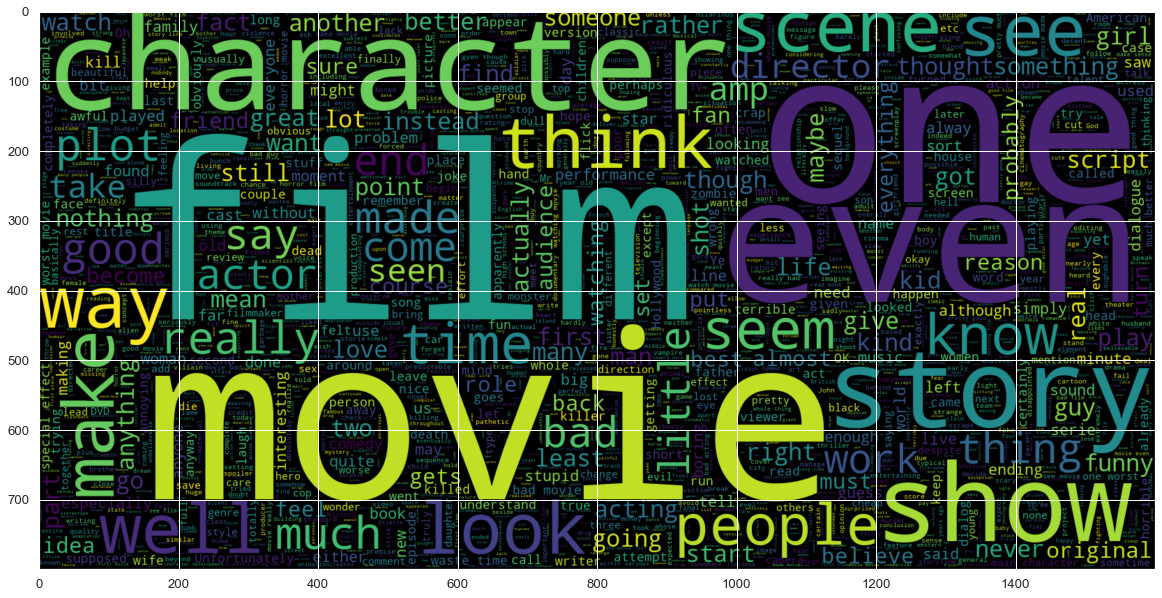

In [146]:
#WORDCLOUD FOR NEGATIVE TEXT (LABEL - 0)
plt.figure(figsize = (20,20)) # Positive Review Text
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 0].review))
plt.imshow(wc , interpolation = 'bilinear')

In [112]:
#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

In [113]:
#Apply function on review column
df['review']=df['review'].apply(simple_stemmer)

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
#Count vectorizer for bag of words
cv=CountVectorizer(binary=False,ngram_range=(1,3),max_features=6000)
#transformed train reviews
cv_train_reviews=cv.fit_transform(X_train)
#transformed test reviews
cv_test_reviews=cv.transform(X_test)

In [16]:
from sklearn.naive_bayes import MultinomialNB
clf= MultinomialNB()
clf.fit(cv_train_reviews,y_train)

MultinomialNB()

In [36]:
y_pred=clf.predict(cv_test_reviews)

In [37]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_pred,y_test))

0.8372


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
#Tfidf vectorizer
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews=tv.fit_transform(X_train)
#transformed test reviews
tv_test_reviews=tv.transform(X_test)

In [39]:
dlf= MultinomialNB()
dlf.fit(tv_train_reviews,y_train)

MultinomialNB()

In [40]:
y_pred=dlf.predict(tv_test_reviews)

In [41]:
print(accuracy_score(y_pred,y_test))

0.7637


In [42]:
from sklearn.preprocessing import LabelBinarizer
#labeling the sentiment data
lb=LabelBinarizer()
#transformed sentiment data
sentiment_data=lb.fit_transform(df['sentiment'])
print(sentiment_data.shape)

(50000, 1)


In [50]:
dummy=pd.get_dummies(df['sentiment'])

In [51]:
dummy.head()

,0,1
0,0,1
1,0,1
2,0,1
3,1,0
4,0,1


In [52]:
df2=pd.concat((df,dummy),axis=1)

In [53]:
df2.head()

,review,sentiment,0,1
0,One reviewers mentioned watching 1 Oz episode ...,1,0,1
1,wonderful little production filming technique ...,1,0,1
2,thought wonderful way spend time hot summer we...,1,0,1
3,Basically family little boy Jake thinks zo...,0,1,0
4,Petter Mattei Love Time Money visually stun...,1,0,1


In [55]:
df2.drop(columns=[0],axis=1,inplace=True)

In [56]:
df2=df2.rename(columns={1:'predicted sentiment'})

In [69]:
df2.head()

,review,sentiment,predicted sentiment
0,One reviewers mentioned watching 1 Oz episode ...,1,1
1,wonderful little production filming technique ...,1,1
2,thought wonderful way spend time hot summer we...,1,1
3,Basically family little boy Jake thinks zo...,0,0
4,Petter Mattei Love Time Money visually stun...,1,1
